Our problem to solve was a modified version of the Travel Salesman Problem: additionally, we have cost associated with each node, and we had to select exactly 50% of the total nodes.

# Code

In [26]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

In [27]:

tsp_a = pd.read_csv("../Lab1/TSPA.csv", sep=';', header=None)
tsp_b = pd.read_csv("../Lab1/TSPB.csv", sep=';', header=None)

tsp_a

,0,1,2
0,1510,353,84
1,3042,123,483
2,2145,389,1462
3,1030,365,1986
4,2125,360,145
...,...,...,...
195,1023,1258,197
196,3192,1271,1183
197,3735,1879,1461
198,3983,299,1309


In [86]:
tsp_b

,0,1,2
0,2907,1115,928
1,3433,183,1864
2,2237,74,260
3,91,583,1006
4,3053,1867,993
...,...,...,...
195,1252,970,1882
196,613,784,439
197,3139,470,597
198,2465,1165,570


In [100]:
def generate_dm(df, show=True):
    temp = df[[0, 1]].to_numpy()
    dm = distance_matrix(temp, temp)

    temp = df[2].to_numpy() // 2
    temp = temp * np.ones((200 , 200))
    dm = dm + temp + temp.T
    dm = np.around(dm)
    #     dm = dm // 1

    for i in range(df.shape[0]):
        dm[i][i] = np.inf

    if show:
        df_dist = pd.DataFrame(dm)
        display(df_dist)
    return dm


### Regret

In [30]:
dm = generate_dm(tsp_a, False)
dm.shape

(200, 200)

In [31]:
def get_nodes(edge: str):
    return [int(i) for i in edge.split('_')]

In [76]:
# start_node_idx = 1
def f(start_node_idx, dm, data, weight_regret=1, weight_cost=0, return_cycle=False):
    data_indexes = data.index.to_list()
    if start_node_idx is None:
        start_node_idx = random.choice(data_indexes)

    node = data_indexes[start_node_idx]
    next_node = dm[node].argmin()

    data_indexes.remove(node)
    data_indexes.remove(next_node)

    edge1 = str(node) + '_' + str(next_node)
    edge2 = str(next_node) + '_' + str(node)
    cycle = [edge1, edge2]

    #for, sort1, sort2, total
    while len(cycle) < data.shape[0] // 2:
        store = []

        for node in data_indexes:
            options = []
            for edge in cycle:
                old_node1, old_node2 = [int(i) for i in edge.split('_')]
                change = dm[old_node1][node] + dm[old_node2][node] - dm[old_node1][old_node2]
                options.append((edge, change))
            options.sort(key=lambda x: x[1])  #here
            regret = options[0][1] - options[1][1]
            value = weight_regret * regret + weight_cost * options[0][1]
            store.append((node, options[0][0], value))

        store.sort(key=lambda x: x[2])

        best = store[0]
        cycle.remove(best[1])
        data_indexes.remove(best[0])
        old_node1, old_node2 = [int(i) for i in best[1].split('_')]
        cycle.append(str(old_node1) + '_' + str(best[0]))
        cycle.append(str(best[0]) + '_' + str(old_node2))

    total = 0
    for edge in cycle:
        node1, node2 = [int(i) for i in edge.split('_')]
        total += dm[node1][node2]

    if return_cycle:
        return total, cycle
    else:
        return total


## Instnace A


### Greedy 2-regret heuristics

In [78]:
totals = []
history = []
for i in tqdm(range(200)):
    totals.append(f(i, dm,tsp_a))
#     history.append(f(i,dm)[1])
totals = np.array(totals)
print("Best score: ", totals.min())
print("Worst score: ", totals.max())
print("Mean score: ", totals.mean())

100%|██████████| 200/200 [03:03<00:00,  1.09it/s]

Best score:  109024.0
Worst score:  123981.0
Mean score:  116162.58


Problem with 2-regret: 1st choice is aribtrary(when we have only 2 nodes in cycle, regretes for all other nodes are the same)

94


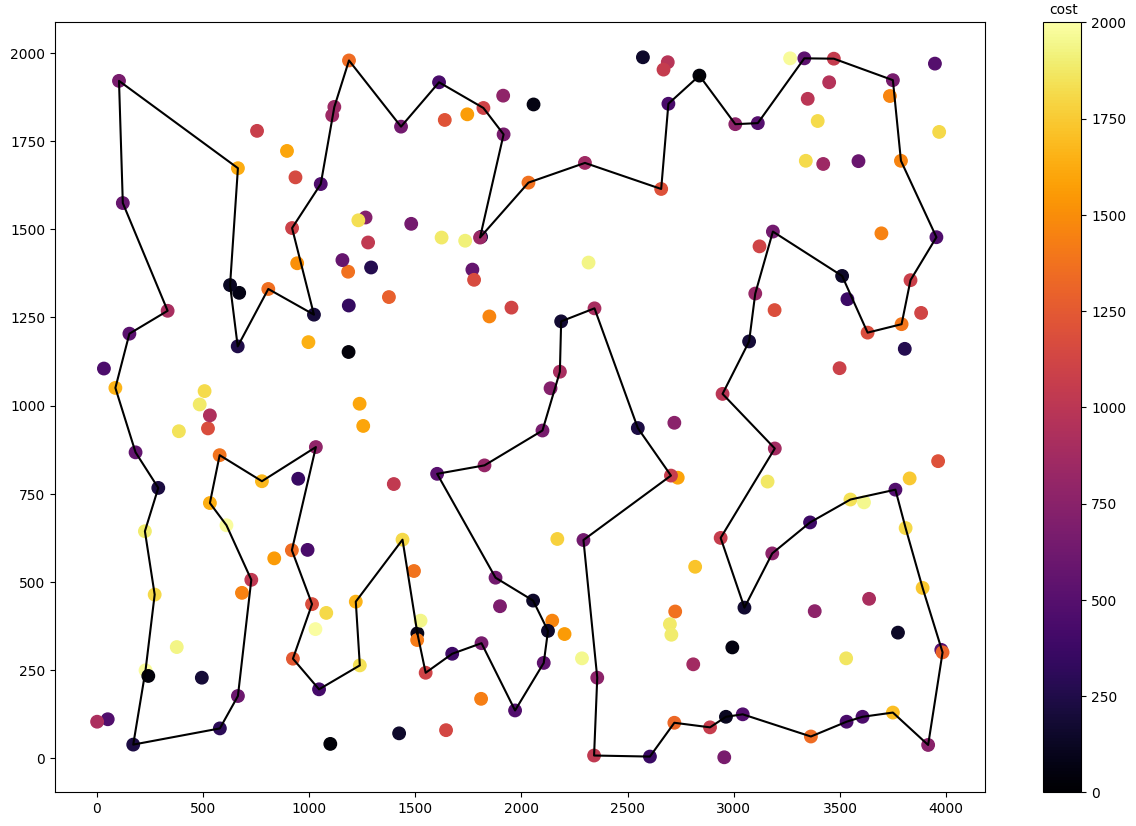

In [79]:
best_sol = totals.argmin()
print(best_sol)
sore, cycle  = f(best_sol, dm,tsp_a, 1, 0, True)
cycle = [x.split('_') for x in cycle]
order = ['0']
while len(order) < 100:
    for n1, n2 in cycle:
        if n1 == order[-1]:
            order.append(n2)

order = [int(x) for x in order]
cycle = tsp_a.loc[order]
cycle = cycle.append(cycle.iloc[0])
# cycle

plt.figure(figsize=(15, 10))
plt.scatter(tsp_a[0], tsp_a[1], 80, tsp_a[2], cmap='inferno')
plt.clim(0, 2000)
plt.colorbar().set_label('cost', labelpad=-45, y=1.025, rotation=0)
plt.plot(cycle[0], cycle[1], c='black')
plt.show()

### Greedy heuristics with a weighted sum criterion


In [80]:
totals = []
history = []
for i in tqdm(range(200)):
    totals.append(f(i, dm,tsp_a,0.5,0.5))
totals = np.array(totals)
print("Best score: ", totals.min())
print("Worst score: ", totals.max())
print("Mean score: ", totals.mean())

100%|██████████| 200/200 [03:03<00:00,  1.09it/s]

Best score:  74514.0
Worst score:  78926.0
Mean score:  76292.68


32


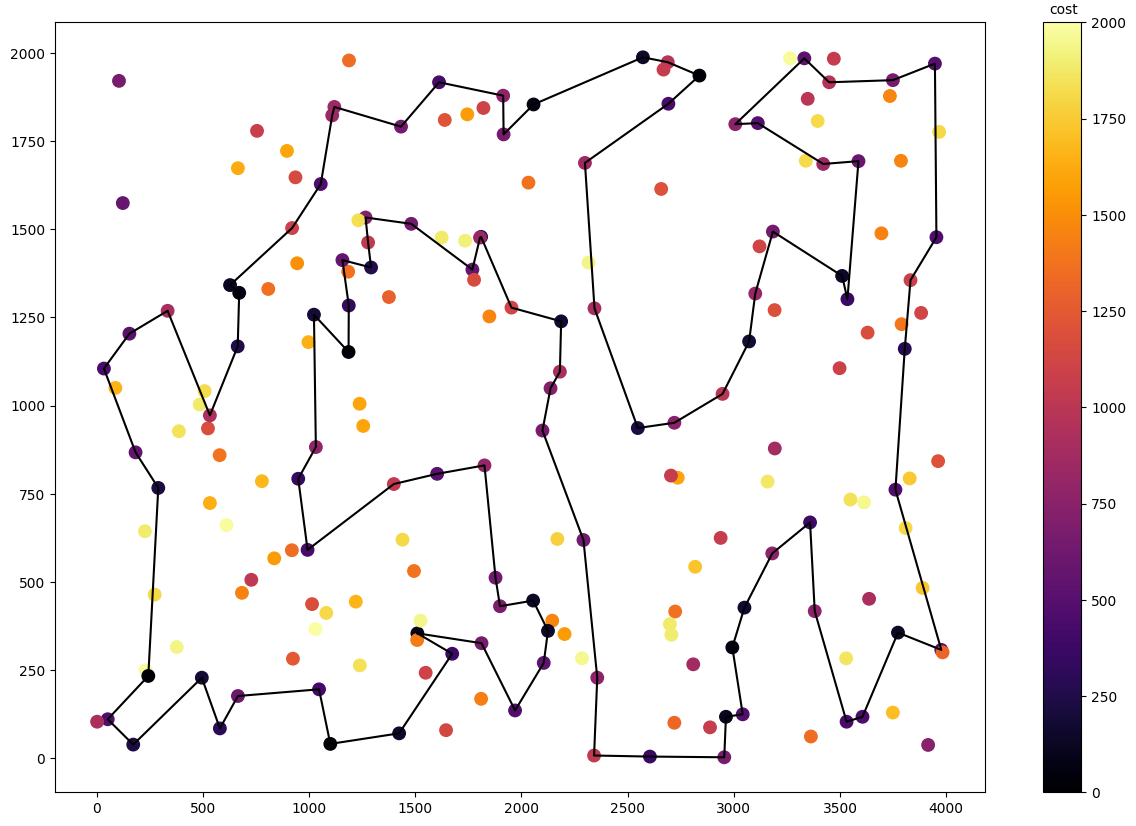

In [81]:
best_sol = totals.argmin()
print(best_sol)
sore, cycle  = f(best_sol, dm,tsp_a, 0.5, 0.5, True)
cycle = [x.split('_') for x in cycle]
order = ['0']
while len(order) < 100:
    for n1, n2 in cycle:
        if n1 == order[-1]:
            order.append(n2)

order = [int(x) for x in order]
cycle = tsp_a.loc[order]
cycle = cycle.append(cycle.iloc[0])
# cycle

plt.figure(figsize=(15, 10))
plt.scatter(tsp_a[0], tsp_a[1], 80, tsp_a[2], cmap='inferno')
plt.clim(0, 2000)
plt.colorbar().set_label('cost', labelpad=-45, y=1.025, rotation=0)
plt.plot(cycle[0], cycle[1], c='black')
plt.show()

## Instnace B


In [106]:
dm = generate_dm(tsp_b, False)
dm.shape

(200, 200)

### Greedy 2-regret heuristics


In [90]:
totals = []
history = []
for i in tqdm(range(200)):
    totals.append(f(i, dm,tsp_b))
totals = np.array(totals)
print("Best score: ", totals.min())
print("Worst score: ", totals.max())
print("Mean score: ", totals.mean())

100%|██████████| 200/200 [03:06<00:00,  1.07it/s]

Best score:  107990.0
Worst score:  127540.0
Mean score:  118615.42


155


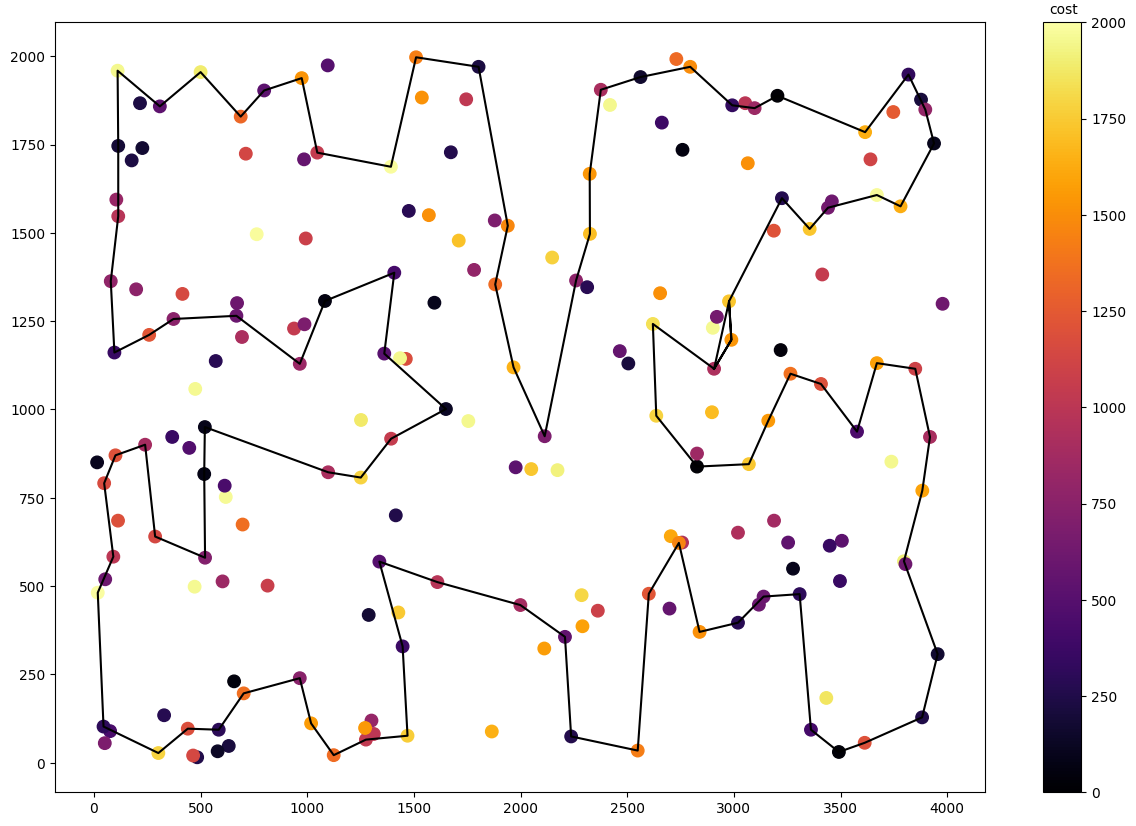

In [103]:
best_sol = totals.argmin()
print(best_sol)
sore, cycle  = f(best_sol, dm,tsp_b, 1, 0, True)
cycle = [x.split('_') for x in cycle]
order = ['0']
while len(order) < 100:
    for n1, n2 in cycle:
        if n1 == order[-1]:
            order.append(n2)

order = [int(x) for x in order]
cycle = tsp_b.loc[order]
cycle = cycle.append(cycle.iloc[0])

plt.figure(figsize=(15, 10))
plt.scatter(tsp_b[0], tsp_b[1], 80, tsp_b[2], cmap='inferno')
plt.clim(0, 2000)
plt.colorbar().set_label('cost', labelpad=-45, y=1.025, rotation=0)
plt.plot(cycle[0], cycle[1], c='black')
plt.show()

### Greedy heuristics with a weighted sum criterion


In [92]:
totals = []
history = []
for i in tqdm(range(200)):
    totals.append(f(i, dm,tsp_b,0.5,0.5))
totals = np.array(totals)
print("Best score: ", totals.min())
print("Worst score: ", totals.max())
print("Mean score: ", totals.mean())

100%|██████████| 200/200 [03:03<00:00,  1.09it/s]

Best score:  69686.0
Worst score:  78503.0
Mean score:  71736.81


155


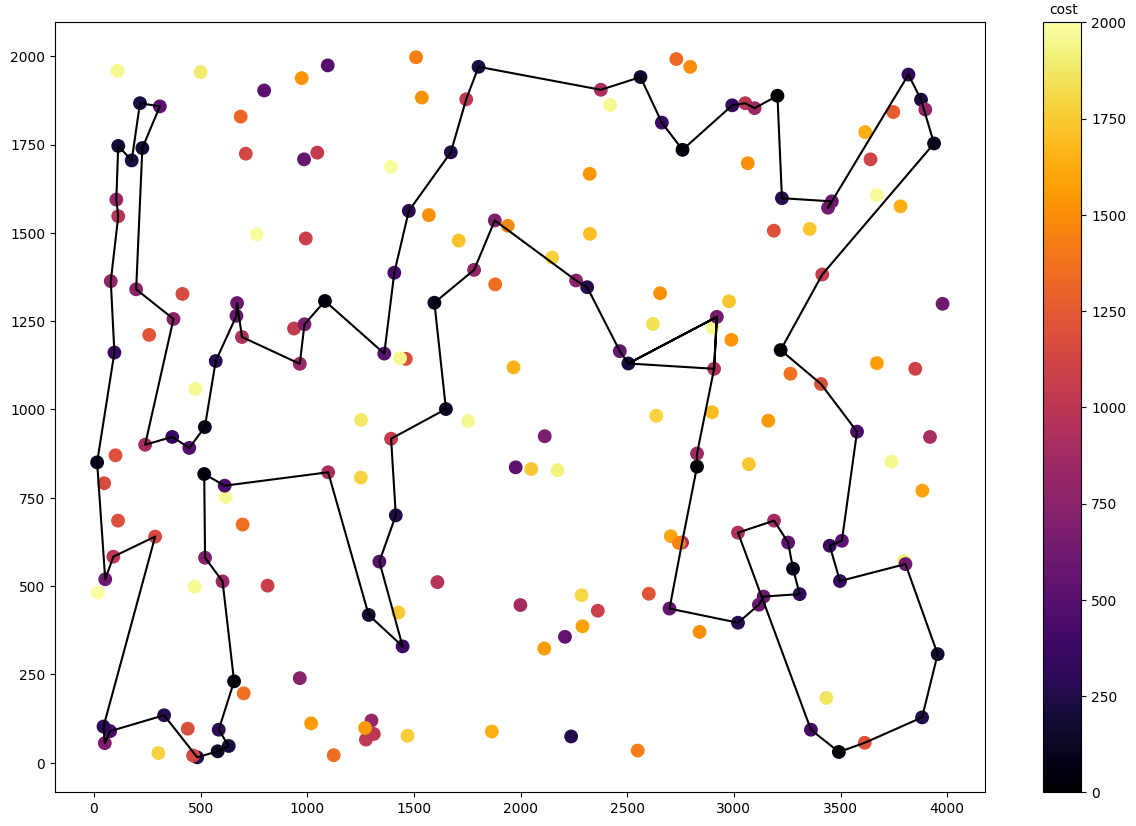

In [107]:
best_sol = totals.argmin()
print(best_sol)
sore, cycle  = f(best_sol, dm,tsp_b, 0.5, 0.5, True)
cycle = [x.split('_') for x in cycle]
order = ['0']

while len(order) < 100:
    for n1, n2 in cycle:
        if n1 == order[-1]:
            order.append(n2)

order = [int(x) for x in order]
cycle = tsp_b.loc[order]
cycle = cycle.append(cycle.iloc[0])
# cycle

plt.figure(figsize=(15, 10))
plt.scatter(tsp_b[0], tsp_b[1], 80, tsp_b[2], cmap='inferno')
plt.clim(0, 2000)
plt.colorbar().set_label('cost', labelpad=-45, y=1.025, rotation=0)
plt.plot(cycle[0], cycle[1], c='black')
plt.show()